<a href="https://colab.research.google.com/github/entelecheia/413A/blob/main/notebooks/05/02_Decision-Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees

In [18]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Data

We'll consider [a dataset of Titanic passengers](https://www.kaggle.com/c/titanic/) and develop a model to predict whether a particular passenger will survive or not. This is what [the dataset](titanic.csv) looks like:

Here are the variable descriptions for the non-obvious variables:
 * **Survived:**        (0 = No; 1 = Yes)
 * **pclass:**          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 * **sibsp:**           Number of Siblings/Spouses Aboard
 * **parch:**           Number of Parents/Children Aboard
 * **ticket:**          Ticket Number
 * **fare:**            Passenger Fare
 * **cabin:**           Cabin
 * **embarked:**        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


We're trying to decide whether a passenger with particular attributes will survive the Titanic disaster, so the **survival** variable is our label, the other columns are the **features**. 

## Decision Trees with SciKit Learn

Scikit-learn has [a nice decision tree implementation](http://scikit-learn.org/stable/modules/tree.html) which we'll use to learn a tree for our Titanic dataset.

In [2]:
import gdown
import os
id = "155c6OVL0ha1YzUpXk2mBffV7RfWuVx23"

data_file = "titanic.csv"
gdown.download(id=id, output=data_file, quiet=False)
!unzip $data_file

Downloading...
From: https://drive.google.com/uc?id=155c6OVL0ha1YzUpXk2mBffV7RfWuVx23
To: /content/titanic.csv
100%|██████████| 60.3k/60.3k [00:00<00:00, 40.5MB/s]

Archive:  titanic.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of titanic.csv or
        titanic.csv.zip, and cannot find titanic.csv.ZIP, period.


In [3]:
titanic = pd.read_csv(data_file)
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Data cleanup

We need to do some cleanup: 
 * Age has missing values. Let's assume that a person with missing age is of mean age (this is not necessarily a good decision).
 * Embarked has missing values, we add a dedicated category for unknown embarkation points.
 * We need to convert the categorical values to numerical values. 

In [4]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())

def sex_to_numeric(x):
    if x=='male':
        return 0
    if x=='female':
        return 1
    else:
        return x

titanic["Sex"] = titanic["Sex"].apply(sex_to_numeric)
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare Cabin Embarked  
0         A/5 21171   7.2500   NaN        S  
1          PC 17599  71.2833   C85        C  
2  STON/O2. 3101282   7.9250   NaN        S  
3            113803  53.1000  C123        S  
4            373450   8.0500   NaN        S

In [5]:
# this will break if run more than once
def embarked_to_numeric(x):
    if x=="S":
        return 0
    if x=="C":
        return 1
    if x=="Q":
        return 2
    else: 
        return 3
    
titanic["Embarked"] = titanic["Embarked"].apply(embarked_to_numeric)
titanic.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name  Sex        Age  SibSp  \
0                            Braund, Mr. Owen Harris    0  22.000000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.000000      1   
2                             Heikkinen, Miss. Laina    1  26.000000      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.000000      1   
4                           Allen, Mr. William Henry    0  35.000000      0   
5                                   Moran, Mr. James    0  29.699118      0   
6                            McCarthy, Mr. Timothy J    0  54.000000      0   
7                     Palsson, Master. Gosta Leonard    0   2.000000      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)    1  27.000000      0   
9                Nasser, Mrs. Nicholas (Adele Achem)    1  14.000000      1   

   Parch            Ticket     Fare Cabin  Embarked  
0      0         A/5 21171   7.2500   NaN         0  
1      0          PC 17599  71.2833   C85         1  
2      0  STON/O2. 3101282   7.9250   NaN         0  
3      0            113803  53.1000  C123         0  
4      0            373450   8.0500   NaN         0  
5      0            330877   8.4583   NaN         2  
6      0             17463  51.8625   E46         0  
7      1            349909  21.0750   NaN         0  
8      2            347742  11.1333   NaN         0  
9      0            237736  30.0708   NaN         1

Let's work only with the numerical and categorical variables and omit passengerID, Name, Ticket and Cabin. These values could contain some information, but it's hard to make sense of them without more context.

In [6]:
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic = titanic[features]
titanic.head(10)

Survived  Pclass  Sex        Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.000000      1      0   7.2500         0
1         1       1    1  38.000000      1      0  71.2833         1
2         1       3    1  26.000000      0      0   7.9250         0
3         1       1    1  35.000000      1      0  53.1000         0
4         0       3    0  35.000000      0      0   8.0500         0
5         0       3    0  29.699118      0      0   8.4583         2
6         0       1    0  54.000000      0      0  51.8625         0
7         0       3    0   2.000000      3      1  21.0750         0
8         1       3    1  27.000000      0      2  11.1333         0
9         1       2    1  14.000000      1      0  30.0708         1

## Exploring the data

Let's take a look at the data:

In [7]:
titanic.describe()

Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413   29.699118    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.002015    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000   29.699118    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   35.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             Fare    Embarked  
count  891.000000  891.000000  
mean    32.204208    0.368126  
std     49.693429    0.647601  
min      0.000000    0.000000  
25%      7.910400    0.000000  
50%     14.454200    0.000000  
75%     31.000000    1.000000  
max    512.329200    3.000000

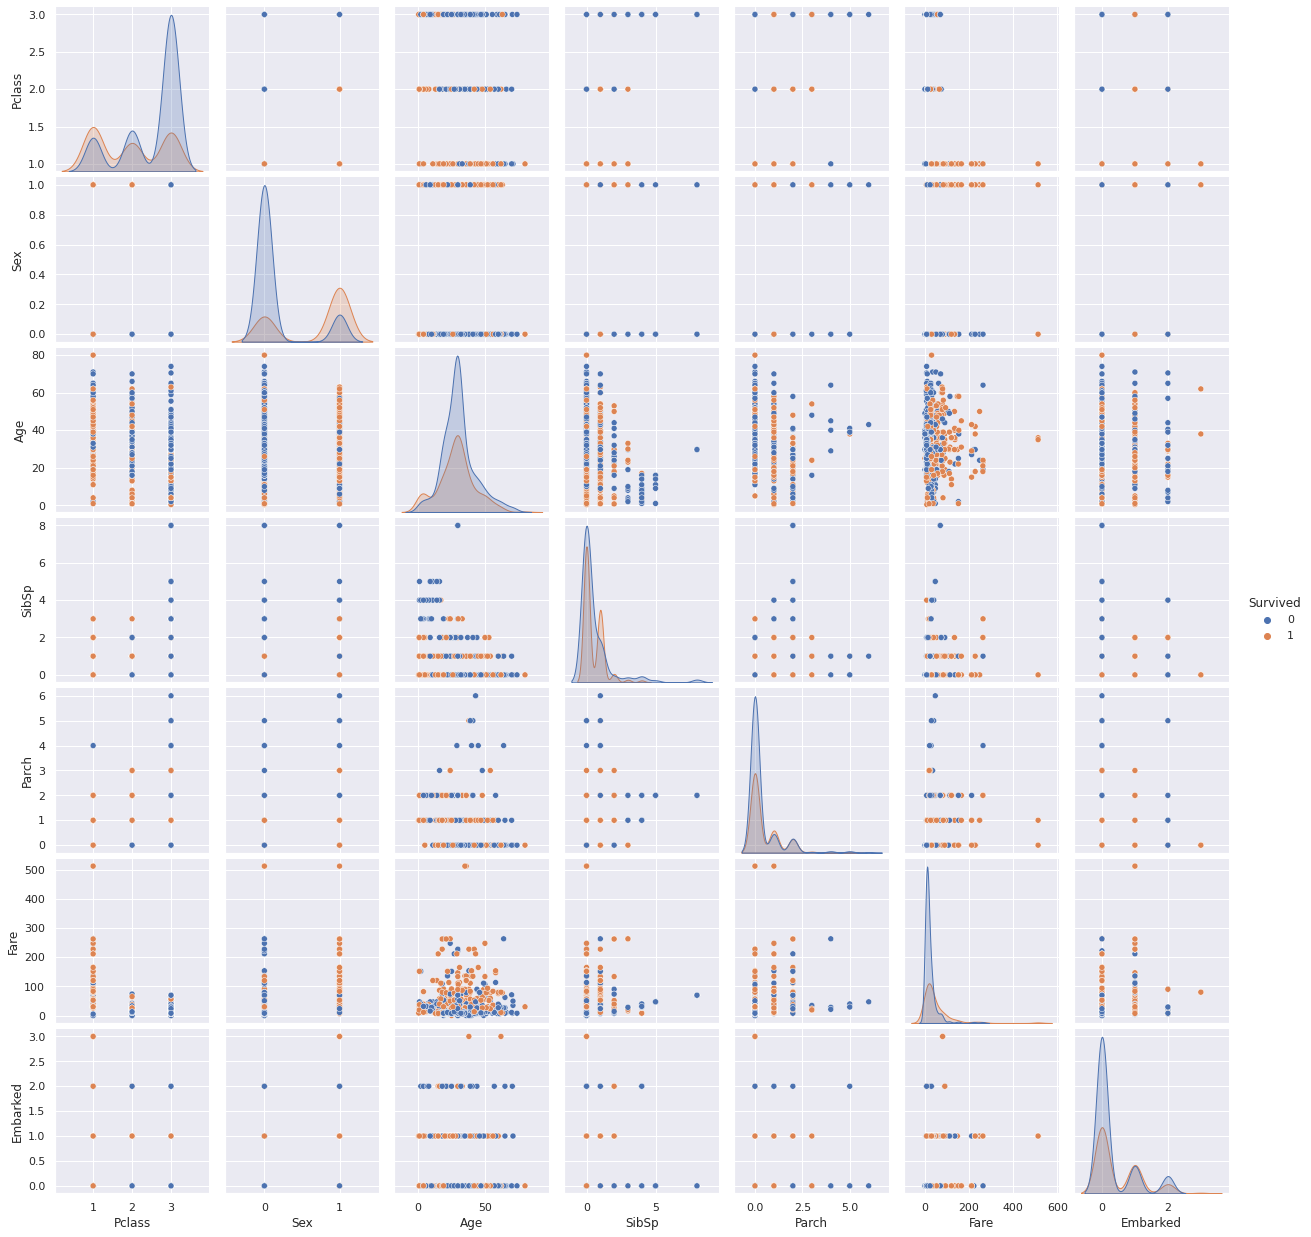

In [8]:
import seaborn as sns
sns.set()
sns.pairplot(titanic, hue="Survived");

## Our first tree
Here is some code that splits the data into training and test sets for cross-validation and selects features.

In [9]:
#labels =["Survived", "Perished"]

def splitData(features):
    """Split a subset of the titanic dataset, given by the features, into train and test sets."""
    titanic_predictors = titanic[features].values
    titanic_labels = titanic["Survived"].values

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(titanic_predictors, titanic_labels, random_state=1, test_size=0.5)
    return XTrain, XTest, yTrain, yTest

And more code for plotting decision trees:

In [10]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Perished", "Survived"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

Now let's look at a decision tree that **ONLY operates on sex**! 

Accuracy on training data =  0.8112359550561797
Accuracy on test data =  0.7623318385650224


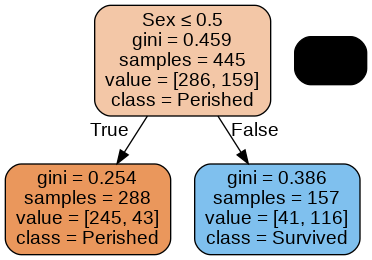

In [11]:
decisionTree = tree.DecisionTreeClassifier()

XTrain, XTest, yTrain, yTest = splitData(["Sex"])
# fit the tree with the traing data
decisionTree = decisionTree.fit(XTrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(XTrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(XTest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

renderTree(decisionTree, ["Sex"])

## Adding more features

Let's add the number of siblings and spouses as a feature. 

Accuracy on training data=  0.8337078651685393
Accuracy on test data=  0.7600896860986547


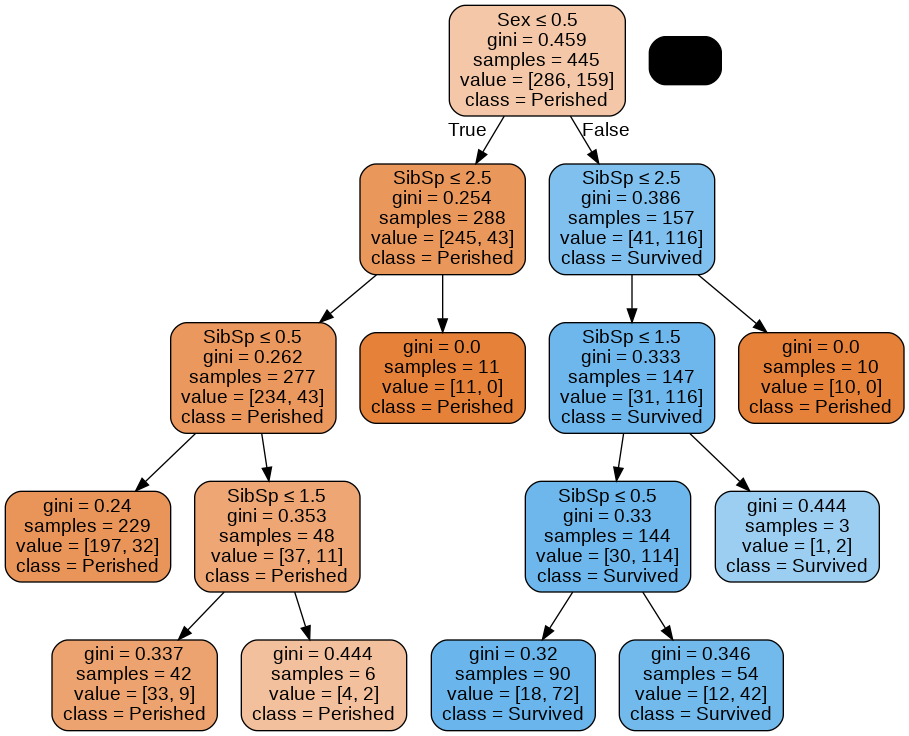

In [12]:
#  train tree on sex and the number of the number of siblings/spouses aboard
used_features = ["Sex", "SibSp"]
XTrain, XTest, yTrain, yTest = splitData(used_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, used_features)

Accuracy on training data=  0.9887640449438202
Accuracy on test data=  0.7556053811659192


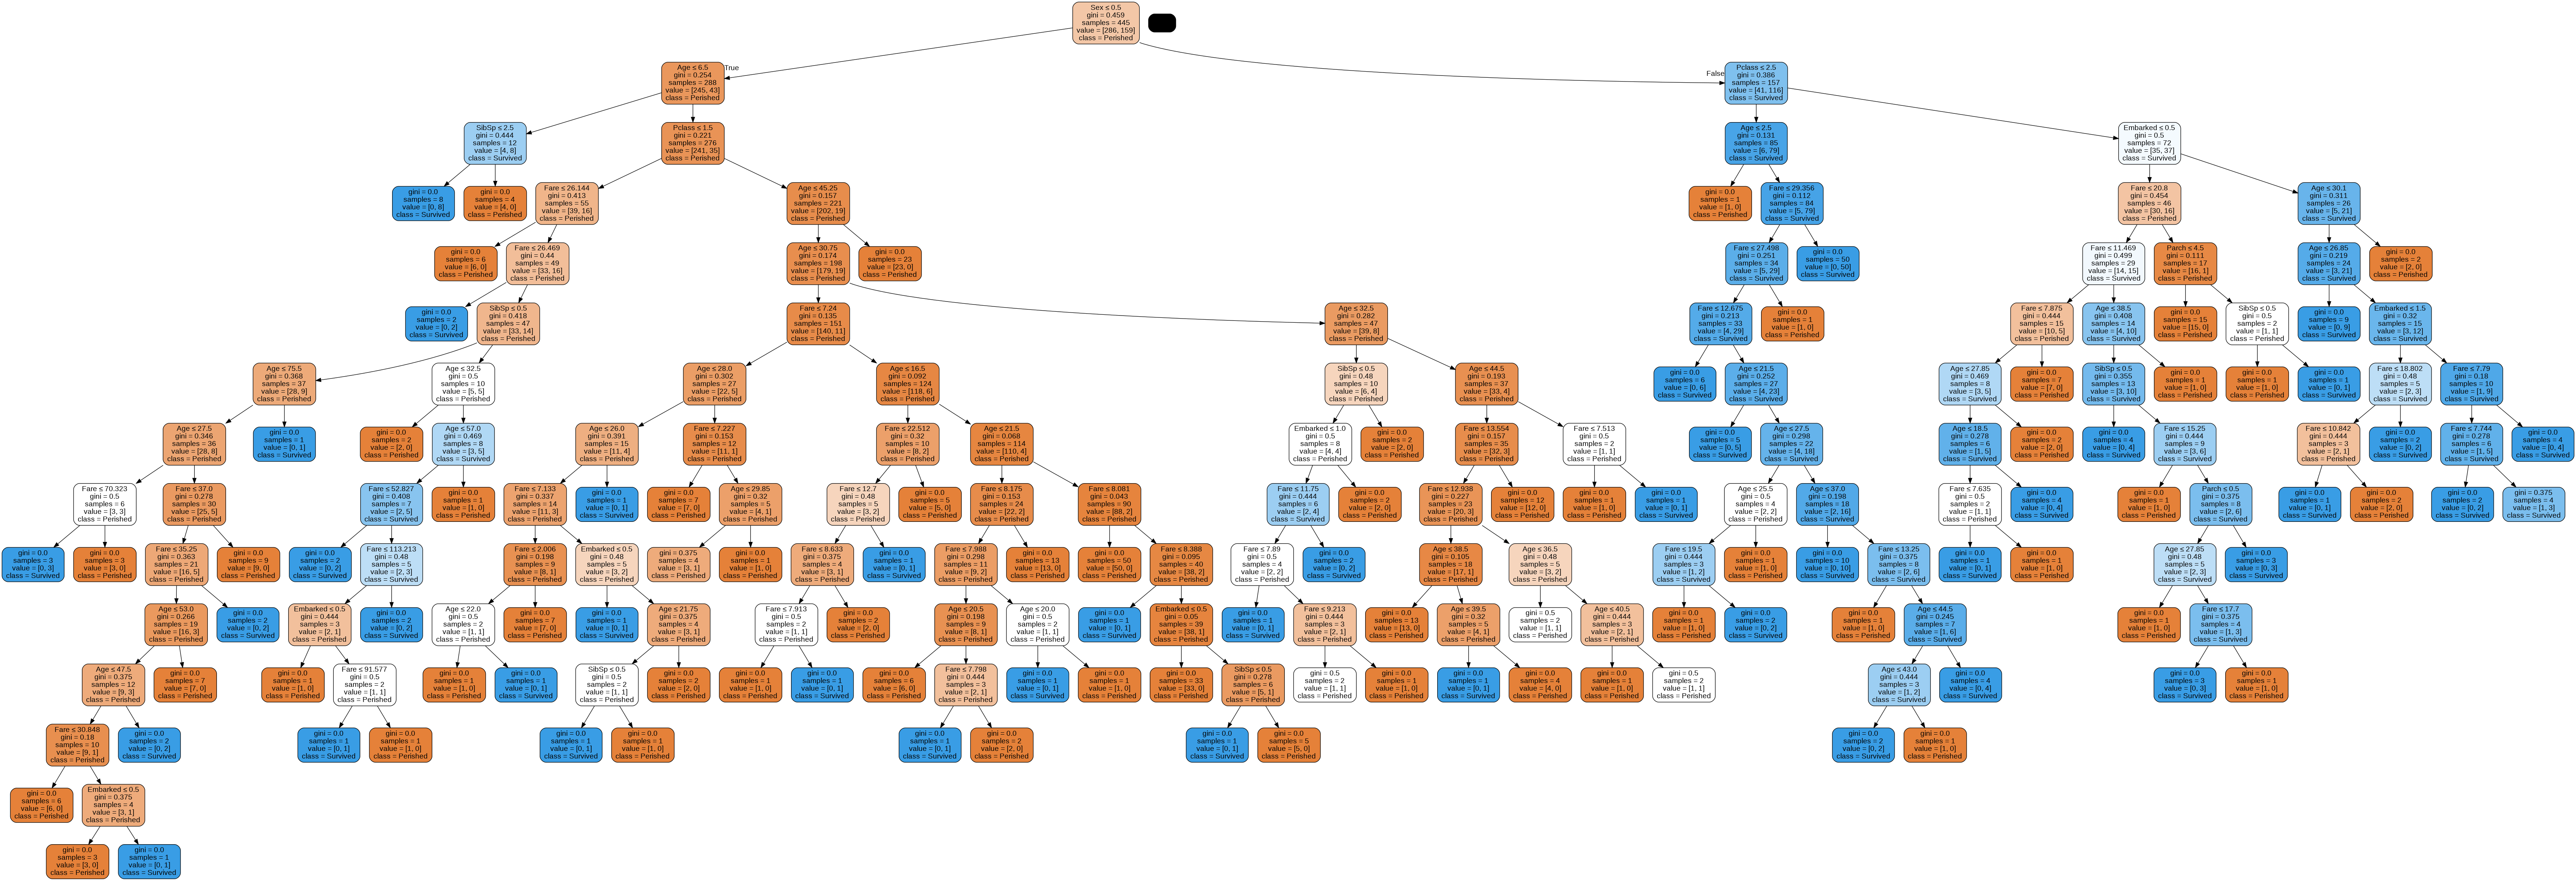

In [13]:
all_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

XTrain, XTest, yTrain, yTest = splitData(all_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Let's try combinations of depth and min split size:

Accuracy on training data=  0.8629213483146068
Accuracy on test data=  0.7937219730941704


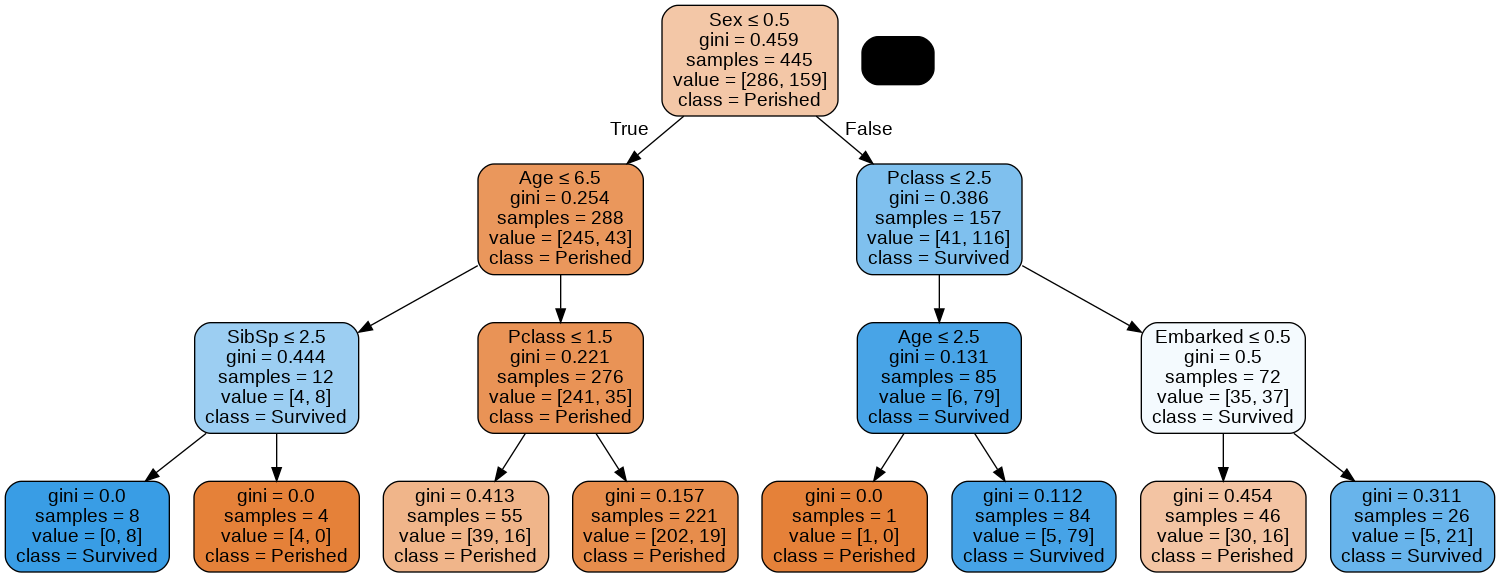

In [14]:
# Limiting Depth!
decisionTree = tree.DecisionTreeClassifier(max_depth=3)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.8943820224719101
Accuracy on test data=  0.7757847533632287


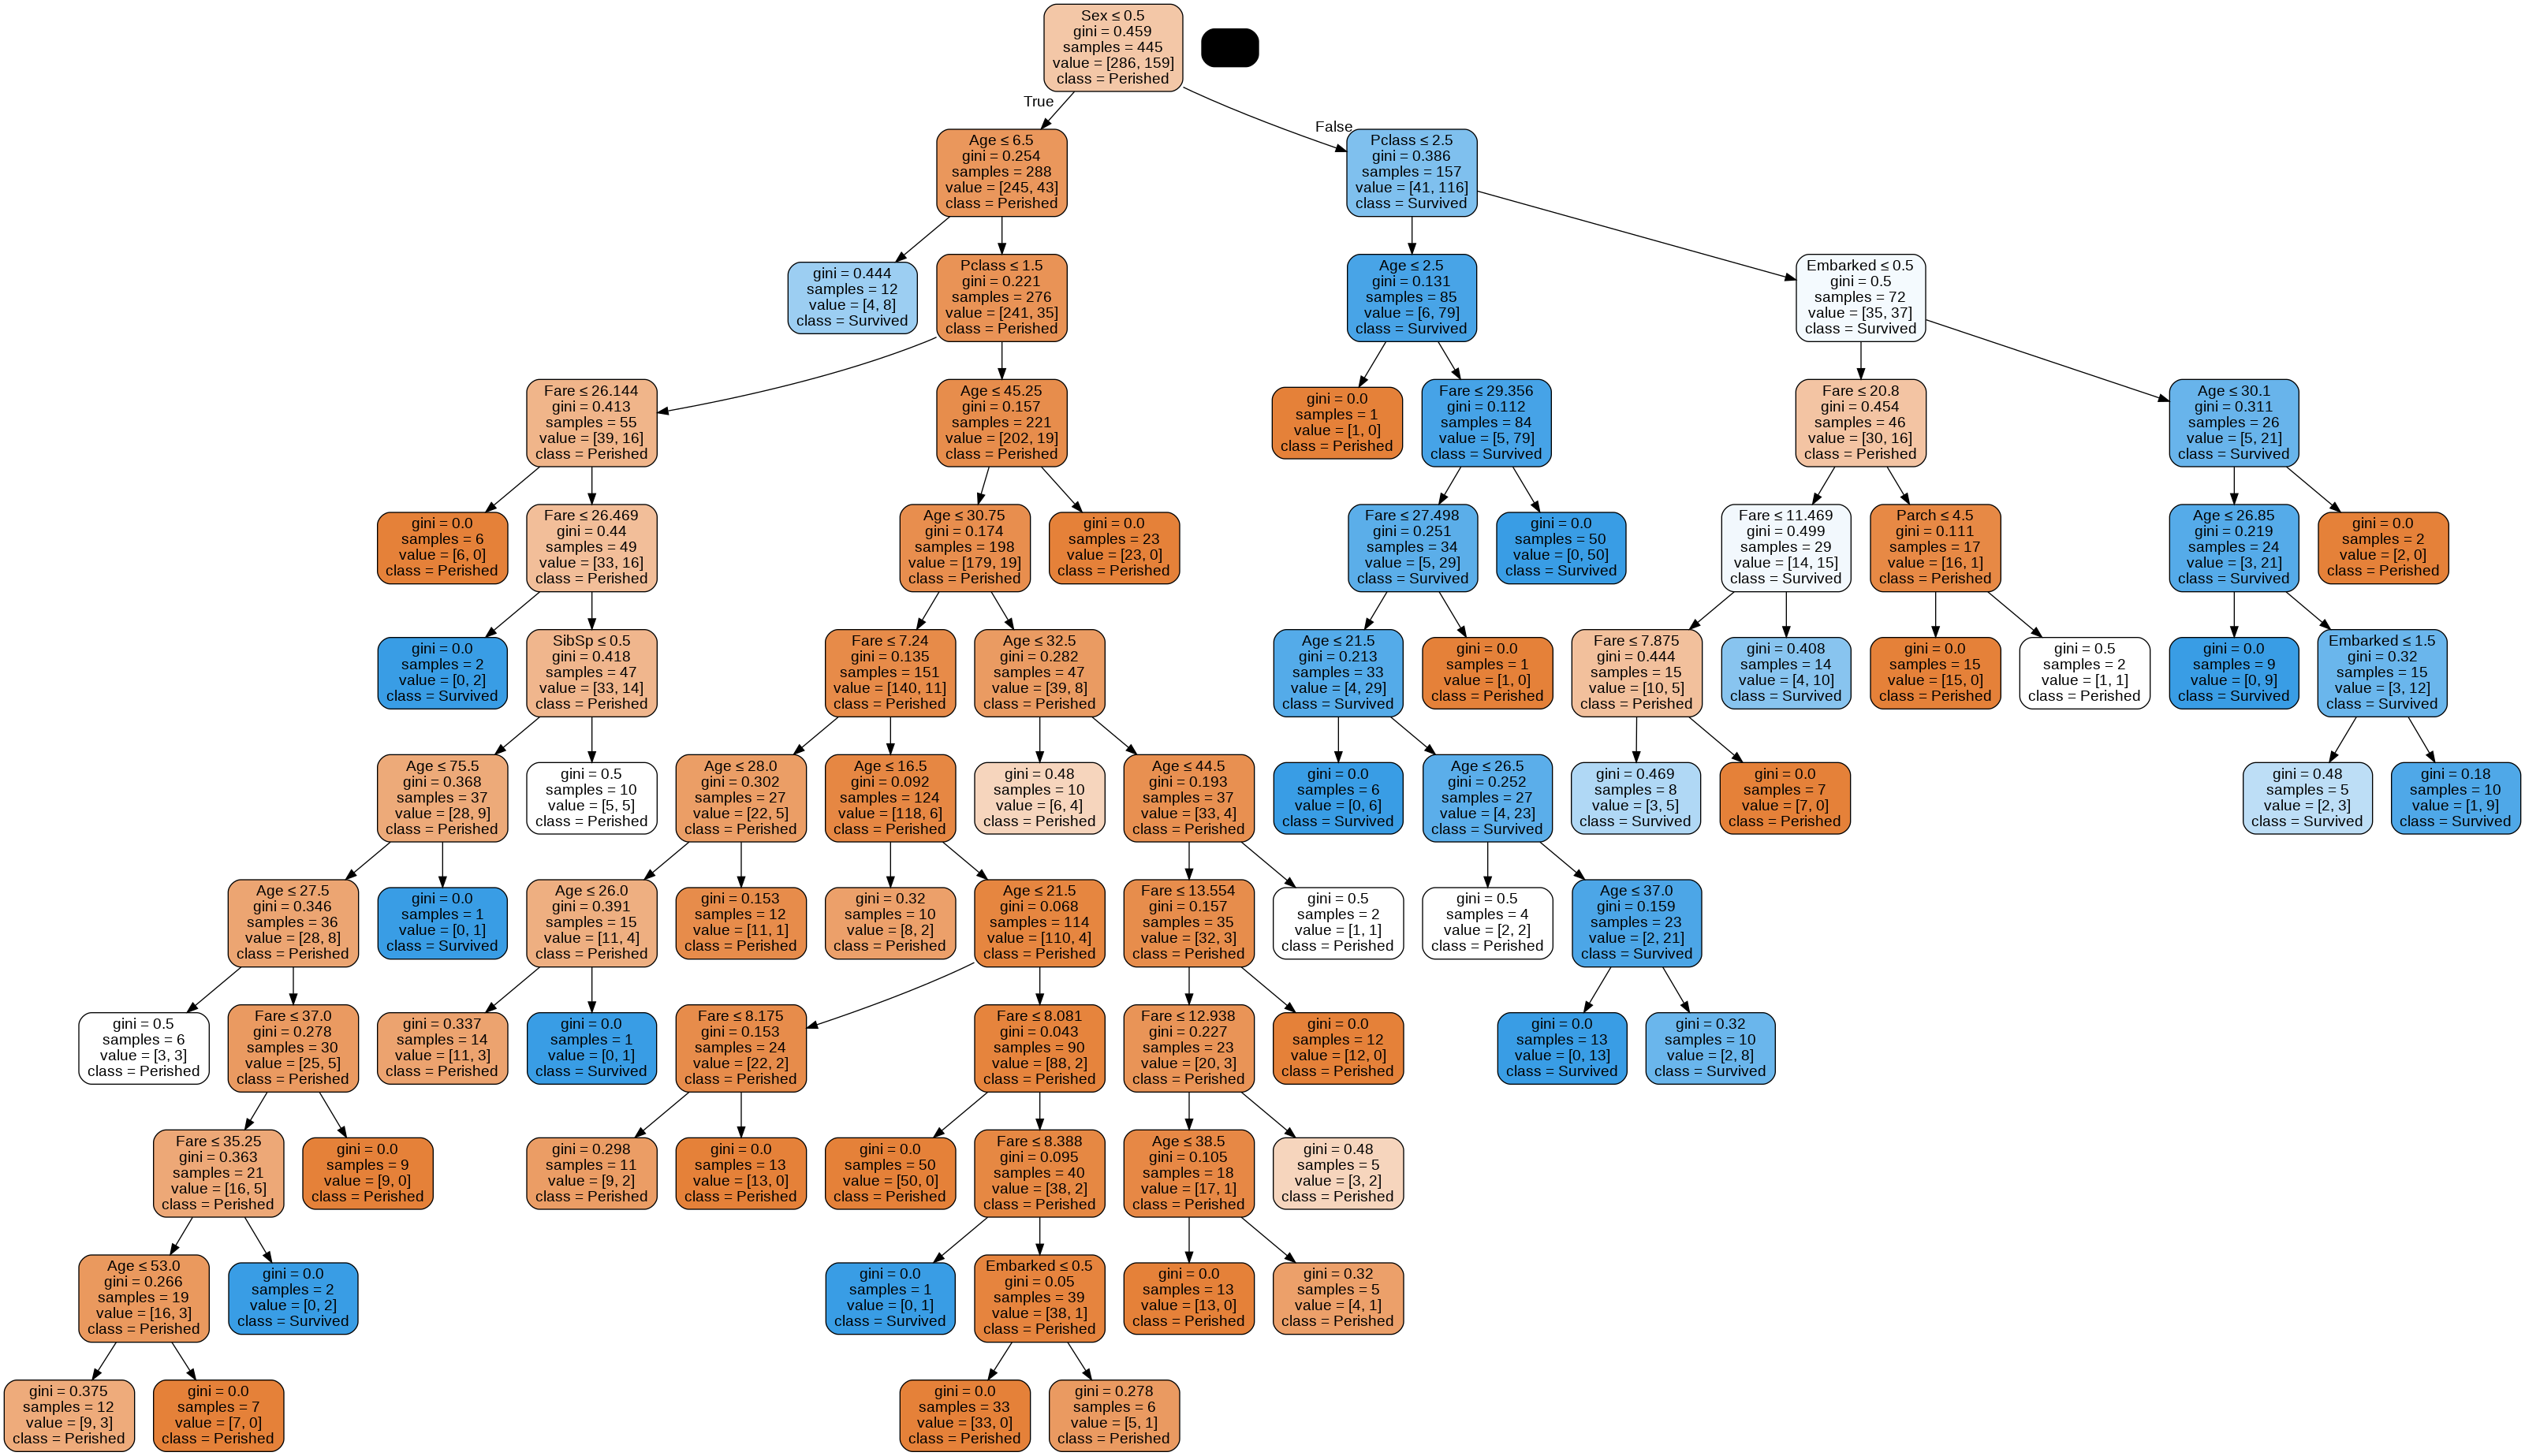

In [15]:
# Lmiting the minimum samples used to split.
decisionTree = tree.DecisionTreeClassifier(min_samples_split=15)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.8629213483146068
Accuracy on test data=  0.7937219730941704


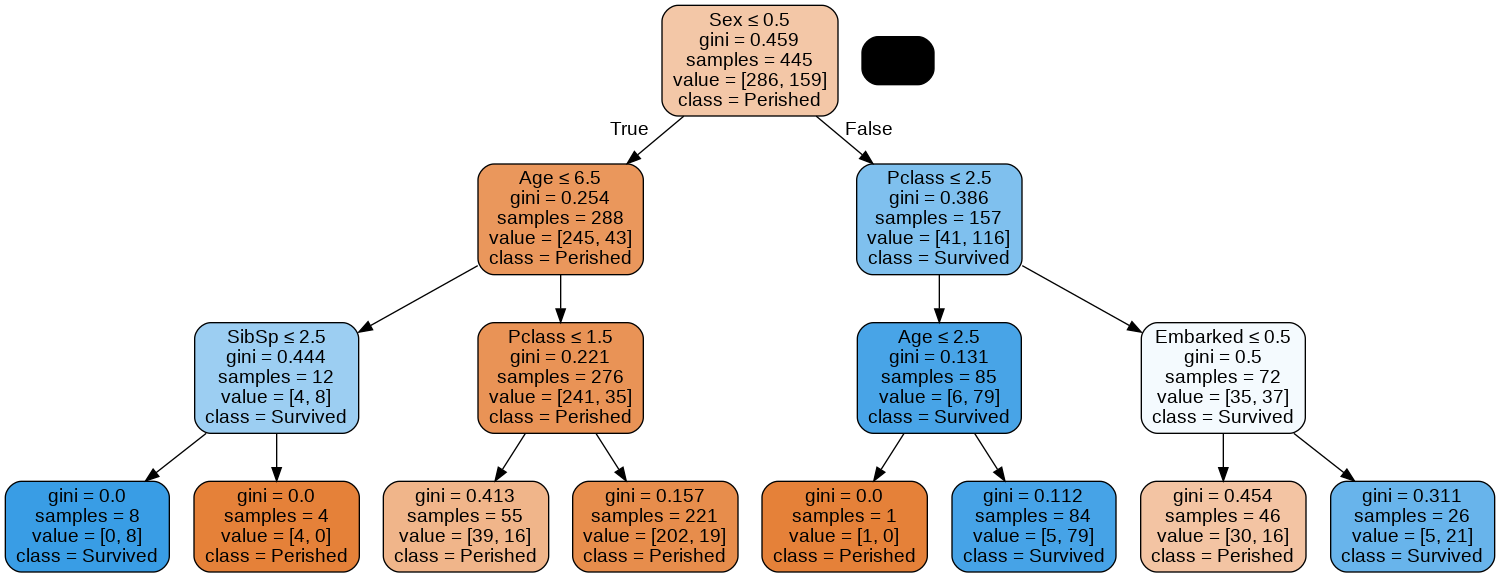

In [16]:
# Limiting Both

decisionTree = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=10)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

## Ensemble Methods based on Decision Trees

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest =  RandomForestClassifier(bootstrap=True, n_estimators=300, random_state=0)

trained_forest = forest.fit(XTrain, yTrain)

y_pred_train = trained_forest.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = trained_forest.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.9887640449438202
Accuracy on test data=  0.7914798206278026
